<a href="https://colab.research.google.com/github/koya-namba/PyTorch_practice/blob/main/%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# オートエンコーダー

入力を復元できる潜在空間を見つける

教師データは自分自身．自己教師あり学習．

再構成誤差が損失関数．

潜在空間の利点　→ データ量を減らすことが可能

## ライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## デバイスの確認

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## データの前処理

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor()
])

In [5]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## モデルの構築

AEは，全結合層で実装も可能．

今回は，畳み込み層を用いて実行．

デコーダを実装するときは，MaxPool2dではなく，Upsampleを用いる．
このとき，scale_factorを用いる．チャネル数の変更も忘れずに．

今回は，Tanhを使ってみる．

In [9]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.en = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.de = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8, out_channels=11, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.en(x)
        x = self.de(x)
        return x

## 学習

In [10]:
model = ConvAE()

In [11]:
model.to(device)

ConvAE(
  (en): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (de): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(8, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

オートエンコーダーの時は，MSELossを用いる．

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

今回はラベルを扱わない．

In [14]:
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, imgs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader)
    losses.append(running_loss)
    print('epoch: {}, loss: {}'.format(epoch, running_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 11, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 0.011654210289071003
epoch: 1, loss: 0.005129089101900657
epoch: 2, loss: 0.004361395529533426
epoch: 3, loss: 0.004004260485619307
epoch: 4, loss: 0.003815173231934508
epoch: 5, loss: 0.0036884524160375196
epoch: 6, loss: 0.003594832871481776
epoch: 7, loss: 0.003519057940815886
epoch: 8, loss: 0.0034589219370236
epoch: 9, loss: 0.0034086664248257877
epoch: 10, loss: 0.003360385501012206
epoch: 11, loss: 0.0033184835474938156
epoch: 12, loss: 0.003285115472972393
epoch: 13, loss: 0.003251192693412304
epoch: 14, loss: 0.0032218045515318714


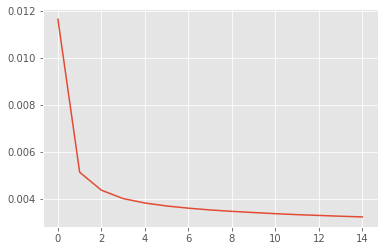

In [16]:
plt.style.use('ggplot')
plt.plot(losses)

## データをエンコード・デコード

In [17]:
data_iter = iter(train_loader)

In [18]:
imgs, _ = data_iter.next()

In [19]:
img = imgs[0]

In [22]:
img_permute = img.permute(1, 2, 0)

heatmapで表示するために，３次元から２次元に変更．

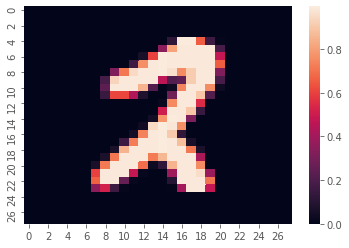

In [23]:
sns.heatmap(img_permute[:, :, 0])

データをGPUに送る

In [24]:
x_en = model.en(imgs.to(device))

In [25]:
x_en2 = x_en[0].permute(1, 2, 0)

複数のチャネルが存在するため今回は，0のみを勾配から引き離して，cpuに持ってくる

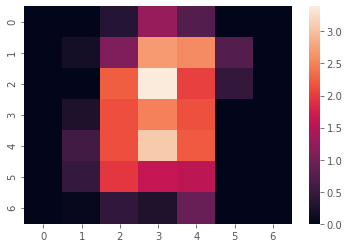

In [27]:
sns.heatmap(x_en2[:, :, 0].detach().to('cpu'))

試しにチャネルを変更してみる．

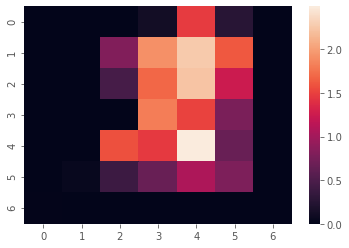

In [30]:
sns.heatmap(x_en2[:, :, 1].detach().to('cpu'))

In [31]:
x_ae = model(imgs.to(device))

0番目のデータをチャネルラストに変更して，勾配を引き離し，cpuにデータを送り，1個目のチャネルを表示．

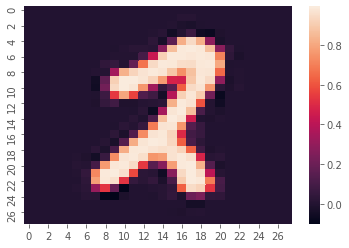

In [32]:
sns.heatmap(x_ae[0].permute(1, 2, 0).detach().to('cpu')[:, :, 0])

## まとめ

### ライブラリのインポート

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### デバイスの確認

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### モデルの構築

In [35]:
transform = transforms.Compose([
                                transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### モデルの構築

In [36]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.en = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.de = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8, out_channels=11, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.en(x)
        x = self.de(x)
        return x

### 学習

In [37]:
model = ConvAE()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, imgs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader)
    losses.append(running_loss)
    print('epoch: {}, loss: {}'.format(epoch, running_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 11, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 0.011700687679151694
epoch: 1, loss: 0.005313495915879806
epoch: 2, loss: 0.004520880753174424
epoch: 3, loss: 0.0041037484291940925
epoch: 4, loss: 0.0038397461878756684
epoch: 5, loss: 0.0036708717330048483
epoch: 6, loss: 0.003565242281059424
epoch: 7, loss: 0.0034873561145116884
epoch: 8, loss: 0.0034237010031938553
epoch: 9, loss: 0.003370365162069599
epoch: 10, loss: 0.0033254616829256215
epoch: 11, loss: 0.0032870975635945795
epoch: 12, loss: 0.003254099340736866
epoch: 13, loss: 0.003221147535617153
epoch: 14, loss: 0.0031917624266197286


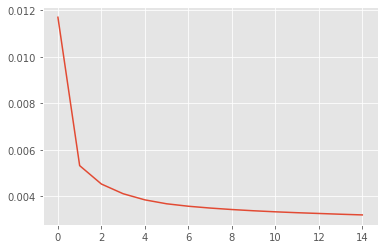

In [38]:
plt.style.use('ggplot')
plt.plot(losses)